In [56]:
import torch
import numpy as np
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

from training import train, validation_epoch
from training_distill import distill_train

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# 0. Preparing a big model

In [62]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [63]:
train_dataset = CIFAR100(root='~/datasets/cifar100', train=True, transform=train_transform, download=True)
test_dataset = CIFAR100(root='~/datasets/cifar100', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=8)

Files already downloaded and verified


In [64]:
from torchvision.models import resnet18
from torch import nn

teacher = resnet18(num_classes=100)
teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
teacher.maxpool = nn.Identity()
teacher = teacher.to(device)

num_epochs = 200
optimizer = torch.optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [65]:
sum(param.numel() for param in teacher.parameters())

11220132

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    teacher, optimizer, scheduler, criterion,
    train_loader, test_loader, num_epochs
)

In [ ]:
torch.save({
    'model': teacher.state_dict()
}, 'resnet18-cifar100.pt')

In [66]:
ckpt = torch.load('resnet18-cifar100.pt')
teacher.load_state_dict(ckpt['model'])
del ckpt

In [67]:
test_loss, test_accuracy = validation_epoch(teacher, criterion, test_loader, tqdm_desc='Validating')
print(f'ResNet-18: test loss = {test_loss:.3f}, test acc = {100 * test_accuracy:.2f}%')

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

ResNet-18: test loss = 0.869, test acc = 78.21%


# 1. Distillation

## 1.1 Training a small model from scratch

In [8]:
from resnet import resnet20

In [9]:
num_epochs = 100
student = resnet20(num_classes=100).to(device)
optimizer = torch.optim.SGD(student.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [10]:
sum(param.numel() for param in student.parameters())

275572

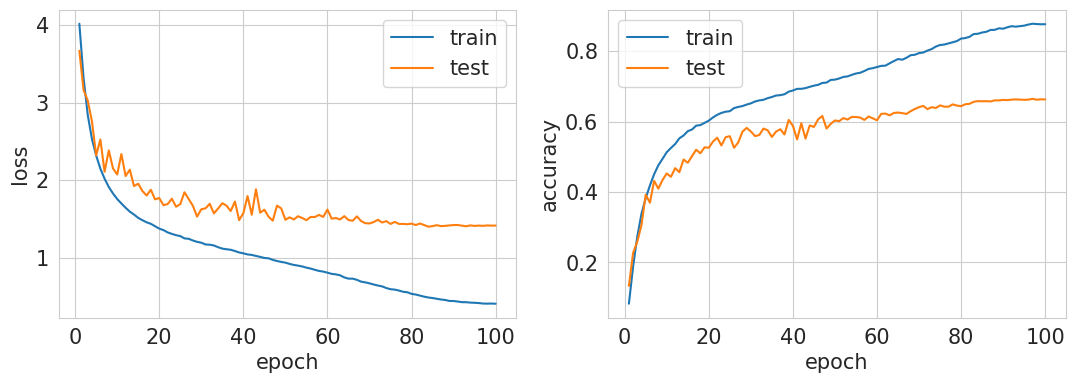

In [11]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    student, optimizer, scheduler, criterion,
    train_loader, test_loader, num_epochs
)

In [12]:
test_loss, test_accuracy = validation_epoch(student, criterion, test_loader, tqdm_desc='Validating')
print(f'ResNet-20: test loss = {test_loss:.3f}, test acc = {100 * test_accuracy:.2f}%')

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

ResNet-20: test loss = 1.414, test acc = 66.26%


## 1.2 Training a small model with knowledge distillation

In [20]:
import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def __init__(self, temp=1, alpha=0.5):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.temp = temp
        self.alpha = alpha

    def forward(self, student_logits, teacher_logits, labels):
        student_log_probs = F.log_softmax(student_logits / self.temp, dim=-1)
        with torch.no_grad():
            teacher_probs = F.softmax(teacher_logits / self.temp, dim=-1)

        distill_loss = -(teacher_probs * student_log_probs).sum(dim=-1).mean() * self.temp ** 2
        ce_loss = self.ce(student_logits, labels)
        return self.alpha * distill_loss + (1 - self.alpha) * ce_loss

In [21]:
num_epochs = 100
student = resnet20(num_classes=100).to(device)
optimizer = torch.optim.SGD(student.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
criterion = DistillationLoss(temp=6, alpha=0.95)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

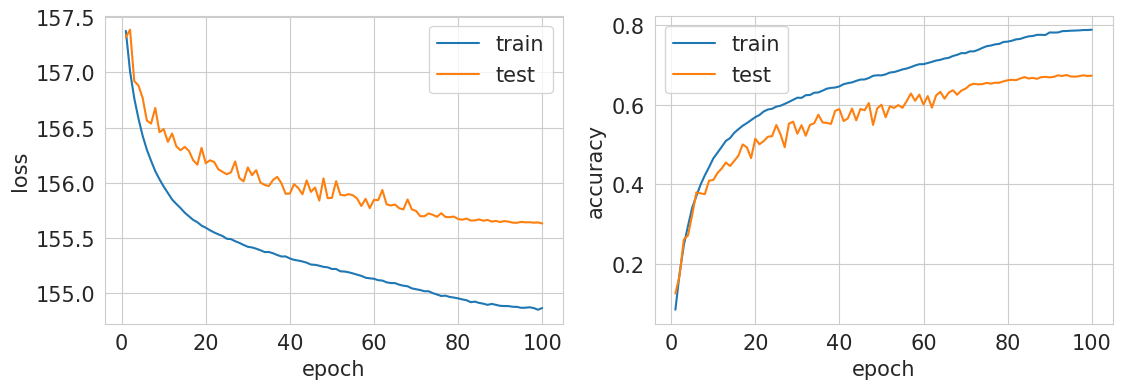

In [22]:
train_losses, test_losses, train_accuracies, test_accuracies = distill_train(
    student, teacher, optimizer, scheduler, criterion,
    train_loader, test_loader, num_epochs
)

In [23]:
test_loss, test_accuracy = validation_epoch(student, nn.CrossEntropyLoss(), test_loader, tqdm_desc='Validating')
print(f'ResNet-20: test loss = {test_loss:.3f}, test acc = {100 * test_accuracy:.2f}%')

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

ResNet-20: test loss = 1.297, test acc = 67.30%


# 2. Pruning

[Pytorch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html)

## 2.1 Amount of pruning

In [24]:
import torch.nn.utils.prune as prune
from time import time
from copy import deepcopy

In [26]:
keys = ('L1 unstructured', 'Random unstructured')
amounts = np.arange(0, 1.01, 0.1)
funcs = (prune.l1_unstructured, prune.random_unstructured)

pruned_loss = np.zeros((len(keys), len(amounts)))
pruned_acc = np.zeros((len(keys), len(amounts)))
pruned_time = np.zeros((len(keys), len(amounts)))


def prune_model(model, prune_func, prune_kwargs):
    pruned_model = deepcopy(model)

    for module in pruned_model.modules():
        if isinstance(module, nn.Conv2d):
            prune_func(module, name='weight', **prune_kwargs)
            prune.remove(module, 'weight')

    return pruned_model


for i, amount in enumerate(tqdm(amounts)):
    for j, func in enumerate(funcs):
        pruned_teacher = prune_model(teacher, func, {'amount': amount})
        start_time = time()
        pruned_loss[j, i], pruned_acc[j, i] = validation_epoch(pruned_teacher, nn.CrossEntropyLoss(), test_loader)
        pruned_time[j, i] = time() - start_time

  0%|          | 0/11 [00:00<?, ?it/s]

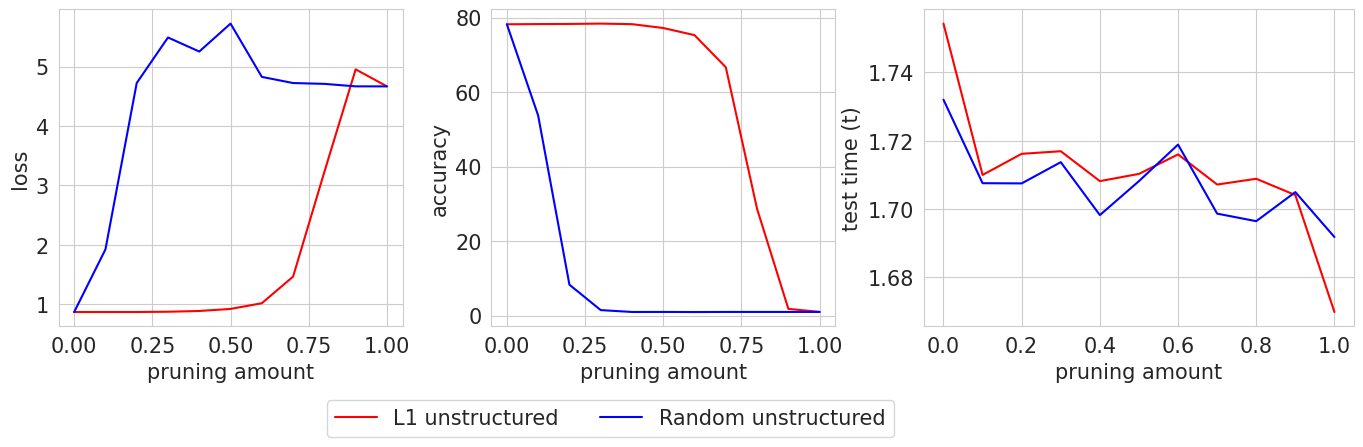

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'width_ratios': [1, 1, 1.25]})
plt.tight_layout()
colors = ['red', 'blue']

for j, key in enumerate(keys):
    axs[0].plot(amounts, pruned_loss[j], label=key, color=colors[j])
    axs[1].plot(amounts, 100 * pruned_acc[j], label=key, color=colors[j])
    axs[2].plot(amounts, pruned_time[j], label=key, color=colors[j])

for ax in axs.flatten():
    ax.set_xlabel('pruning amount')

axs[0].set_ylabel('loss')
axs[1].set_ylabel('accuracy')
axs[2].set_ylabel('test time (t)')

axs[1].legend(ncol=2, bbox_to_anchor=(1.2, -0.2))
plt.show()

## 2.2 Tuning pruned model

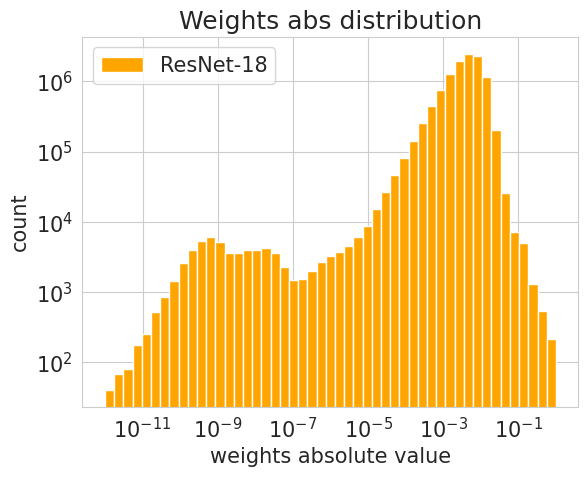

In [28]:
all_weights = np.concatenate([param.cpu().detach().numpy().ravel() for param in teacher.parameters()])
plt.hist(np.abs(all_weights), bins=np.logspace(-12, 0, 50),color='orange', label='ResNet-18')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('weights absolute value')
plt.ylabel('count')
plt.legend()
plt.title('Weights abs distribution')
plt.show()

In [68]:
pruned_teacher = prune_model(teacher, prune.l1_unstructured, {'amount': 0.75})

In [69]:
test_loss, test_accuracy = validation_epoch(pruned_teacher, nn.CrossEntropyLoss(),
                                            test_loader, tqdm_desc='Validating')
print(f'Pruned ResNet-18: test loss = {test_loss:.3f}, test acc = {100 * test_accuracy:.2f}%')

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Pruned ResNet-18: test loss = 2.035, test acc = 54.99%


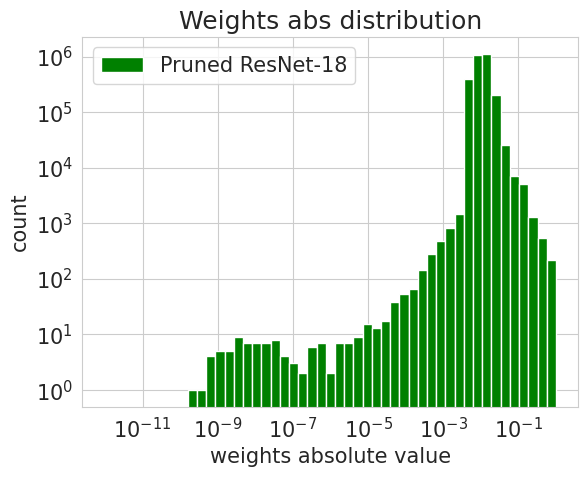

In [70]:
all_weights = np.concatenate([param.cpu().detach().numpy().ravel() for param in pruned_teacher.parameters()])
plt.hist(np.abs(all_weights), bins=np.logspace(-12, 0, 50), color='green', label='Pruned ResNet-18')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('weights absolute value')
plt.ylabel('count')
plt.legend()
plt.title('Weights abs distribution')
plt.show()

In [71]:
num_epochs = 1
iters = 5

for i in range(iters):
    optimizer = torch.optim.SGD(pruned_teacher.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = None

    train_losses, test_losses, train_accuracies, test_accuracies = train(
        pruned_teacher, optimizer, scheduler, criterion,
        train_loader, test_loader, num_epochs, plot=False
    )

    pruned_teacher = prune_model(
        pruned_teacher, prune.l1_unstructured,
        {'amount': 0.75}
    )
    test_loss, test_accuracy = validation_epoch(pruned_teacher, nn.CrossEntropyLoss(), test_loader)
    print(f'Pruned ResNet-18 {i + 1}/{iters}: test loss = {test_loss:.3f}, test acc = {100 * test_accuracy:.2f}%')

Training 1/1:   0%|          | 0/391 [00:00<?, ?it/s]

Validating 1/1:   0%|          | 0/79 [00:00<?, ?it/s]

Pruned ResNet-18 1/5: test loss = 1.210, test acc = 72.91%


Training 1/1:   0%|          | 0/391 [00:00<?, ?it/s]

Validating 1/1:   0%|          | 0/79 [00:00<?, ?it/s]

Pruned ResNet-18 2/5: test loss = 1.011, test acc = 75.90%


Training 1/1:   0%|          | 0/391 [00:00<?, ?it/s]

Validating 1/1:   0%|          | 0/79 [00:00<?, ?it/s]

Pruned ResNet-18 3/5: test loss = 0.952, test acc = 76.53%


Training 1/1:   0%|          | 0/391 [00:00<?, ?it/s]

Validating 1/1:   0%|          | 0/79 [00:00<?, ?it/s]

Pruned ResNet-18 4/5: test loss = 0.931, test acc = 77.06%


Training 1/1:   0%|          | 0/391 [00:00<?, ?it/s]

Validating 1/1:   0%|          | 0/79 [00:00<?, ?it/s]

Pruned ResNet-18 5/5: test loss = 0.914, test acc = 77.52%


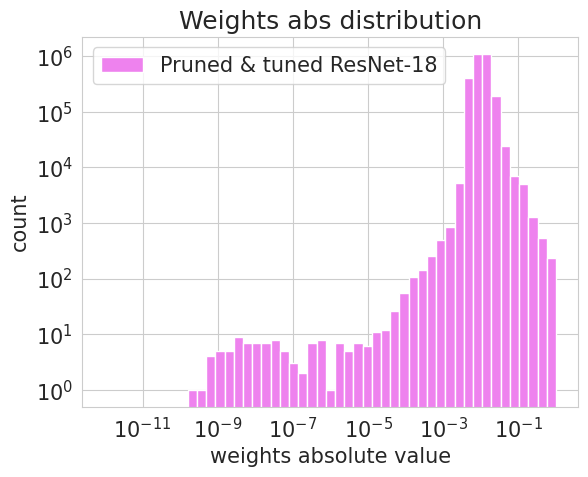

In [73]:
all_weights = np.concatenate([param.cpu().detach().numpy().ravel() for param in pruned_teacher.parameters()])
plt.hist(np.abs(all_weights), bins=np.logspace(-12, 0, 50), color='violet', label='Pruned & tuned ResNet-18')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('weights absolute value')
plt.ylabel('count')
plt.legend()
plt.title('Weights abs distribution')
plt.show()

In [43]:
del pruned_teacher

# 3. Quantization

[PyTorch quantization tutorial](https://pytorch.org/docs/stable/quantization.html)

In [44]:
from torch.utils.data import Subset

train_dataset = CIFAR100(root='~/datasets/cifar100', train=True, transform=train_transform, download=True)
train_dataset = Subset(train_dataset, np.random.randint(low=0, high=len(train_dataset), size=2000))
test_dataset = CIFAR100(root='~/datasets/cifar100', train=False, transform=test_transform)
test_dataset = Subset(test_dataset, np.random.randint(low=0, high=len(test_dataset), size=2000))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

Files already downloaded and verified


In [45]:
device = torch.device('cpu')
teacher = teacher.to(device)

In [46]:
%%time
validation_epoch(teacher, nn.CrossEntropyLoss(), test_loader, tqdm_desc='Validating')

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 39.3 s, sys: 3.76 s, total: 43.1 s
Wall time: 43.2 s


(0.8243418607711792, 0.7975)

In [47]:
from torchvision.models.quantization import resnet18 as q_resnet18

model = q_resnet18(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
model.maxpool = nn.Identity()

In [48]:
ckpt = torch.load('resnet18-cifar100.pt')
model.load_state_dict(ckpt['model'])
del ckpt

model = model.to(device)

In [49]:
# Our initial baseline model which is FP32
model_fp32 = model
model_fp32.eval()

# Sets the backend for x86
model_fp32.qconfig = torch.quantization.get_default_qconfig('TensorRT')

# Prepares the model for the next step i.e. calibration.
# Inserts observers in the model that will observe the activation tensors during calibration
model_fp32_prepared = torch.quantization.prepare(model_fp32, inplace = False)

# Calibrate over the train dataset. This determines the quantization params for activation.
# I used 1000 images of Imagenet train dataset for calibration.
validation_epoch(model_fp32_prepared, nn.CrossEntropyLoss(),
                 train_loader, tqdm_desc='Calibrating')

# Converts the model to a quantized model(int8)
model_int8 = torch.quantization.convert(model_fp32_prepared) # Quantize the model

Calibrating:   0%|          | 0/16 [00:00<?, ?it/s]

In [50]:
%%time
validation_epoch(model_int8, nn.CrossEntropyLoss(), test_loader, tqdm_desc='Validating')

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 31.5 s, sys: 251 ms, total: 31.8 s
Wall time: 31.9 s


(0.8414921989440918, 0.794)